In [ ]:
cd /content/drive/MyDrive/MyProjects/Question_Answering/

/content/drive/MyDrive/MyProjects/Question_Answering


In [ ]:
! nvidia-smi

Wed Apr 28 09:30:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install tokenizers

     |████████████████████████████████| 3.3MB 5.1MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import json
from tokenizers import BertWordPieceTokenizer
import tensorflow_hub as hub

## Loading The Bert Model From Tensorflow Hub

In [ ]:
Bert_Layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = Bert_Layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)

In [ ]:
tokenizer.encode("I love food").tokens

['[CLS]', 'i', 'love', 'food', '[SEP]']

## Preprocessing

In [ ]:
max_seq_len=384

In [ ]:
class Sample:
    def __init__(self, question, context,
                 start_char_idx=None, answer_text=None, 
                 all_answers=None, Tokenizer=tokenizer):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False
        self.start_tok_idx = -1
        self.end_tok_idx = -1
        self.context_token_to_char = None

        self.inputs = {}
        self.targets = []

    def preprocess(self):
        context = " ".join(str(self.context).split())
        question = " ".join(str(self.question).split())

        tokenized_context = tokenizer.encode(context)
        tokenized_question = tokenizer.encode(question)

        if self.answer_text is not None:
            answer = " ".join(str(self.answer_text).split())
            end_char_idx = self.start_char_idx + len(answer)

            if end_char_idx > len(context):           # Might be >=
                self.skip = True
                return

            is_char_in_index = [0]*len(context)
            for idx in range(self.start_char_idx, end_char_idx):
                is_char_in_index[idx] = 1

            ans_token_idx = []
            for idx,(start, end) in enumerate(tokenized_context.offsets):
                if sum(is_char_in_index[start:end])>0:
                    ans_token_idx.append(idx)
            if len(ans_token_idx)==0:
                self.skip=True
                return
            
            self.start_tok_idx = ans_token_idx[0]
            self.end_tok_idx = ans_token_idx[-1]

        input_ids = tokenized_context.ids + tokenized_question.ids[1:]  # [CLS] context [SEP] Question [SEP]
        token_type_ids = [0]*len(tokenized_context.ids) + [1]*len(tokenized_question.ids[1:])
        attention_mask = [1]*len(input_ids)
        padding_length = max_seq_len - len(input_ids)

        if padding_length > 0:
            input_ids = input_ids + ([0]*padding_length)
            token_type_ids = token_type_ids + ([0]*padding_length)
            attention_mask = attention_mask + ([0]*padding_length)
        else:
            self.skip = True
            return 
        
        self.inputs["input_ids"]=input_ids
        self.inputs["token_type_ids"] = token_type_ids
        self.inputs["attention_mask"] = attention_mask

        self.targets = (self.start_tok_idx, self.end_tok_idx)  
        self.context_token_to_char = tokenized_context.offsets            

In [ ]:
def create_squad_examples(raw_data):

    def gen():        
        for item in raw_data["data"]:
            for para in item["paragraphs"]:
                context = para["context"]
                for qa in para["qas"]:
                    question = qa["question"]
                    if "answers" in qa:
                        answer_text = qa["answers"][0]["text"]
                        all_answers = [_["text"] for _ in qa["answers"]]
                        start_char_idx = qa["answers"][0]["answer_start"]
                        squad_eg = Sample(question, context, start_char_idx, answer_text, all_answers)
                    else:
                        squad_eg = Sample(question, context)
                    squad_eg.preprocess()
                    if squad_eg.skip == False:
                        yield (squad_eg.inputs, squad_eg.targets)
                    
    return gen

In [ ]:
class DataLoader:
    def __init__(self,data_path):
        with open(data_path, "r") as f:
            self.raw_data = json.load(f)
        self.datagen = create_squad_examples(self.raw_data)

    def get_data(self, shuffle=False, batch_size=32, buffer_size=2000):
        dataset = tf.data.Dataset.from_generator(self.datagen, output_types=(
            {"input_ids": tf.int32, "token_type_ids": tf.int32, "attention_mask": tf.int32},
            (tf.int32, tf.int32)))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size)
        dataset = dataset.batch(batch_size,drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [ ]:
train_dataloader = DataLoader("Datasets/SQUAD-Train.json")
val_dataloader = DataLoader("Datasets/SQUAD-Dev.json")

In [ ]:
train_data = train_dataloader.get_data(shuffle=True, batch_size=16)
val_data = val_dataloader.get_data(shuffle=False, batch_size=16)

In [ ]:
for i,j in train_data.take(1):
    print(i)
    #print(j)

{'input_ids': <tf.Tensor: shape=(16, 384), dtype=int32, numpy=
array([[  101, 20773,  1005, ...,     0,     0,     0],
       [  101,  1999,  4883, ...,     0,     0,     0],
       [  101, 10266,  2090, ...,     0,     0,     0],
       ...,
       [  101, 20773,  2038, ...,     0,     0,     0],
       [  101,  7524,  2000, ...,     0,     0,     0],
       [  101, 25479,  1005, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(16, 384), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16, 384), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
train_data.element_spec

({'attention_mask': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None),
  'input_ids': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None),
  'token_type_ids': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)},
 (TensorSpec(shape=<unknown>, dtype=tf.int32, name=None),
  TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)))

In [ ]:
def create_model():
    input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="input_mask")
    token_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                        name="input_type_ids")
    
    pooled_output, sequence_output = Bert_Layer([input_ids, attention_mask, token_type_ids])

    start_logits = tf.keras.layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
    start_logits = tf.keras.layers.Flatten()(start_logits)
    end_logits = tf.keras.layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
    end_logits = tf.keras.layers.Flatten()(end_logits)
    start_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(start_logits)
    end_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(end_logits)

    model = tf.keras.Model(inputs={
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids
    },
    outputs=(start_probs, end_probs))
    return model

In [ ]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

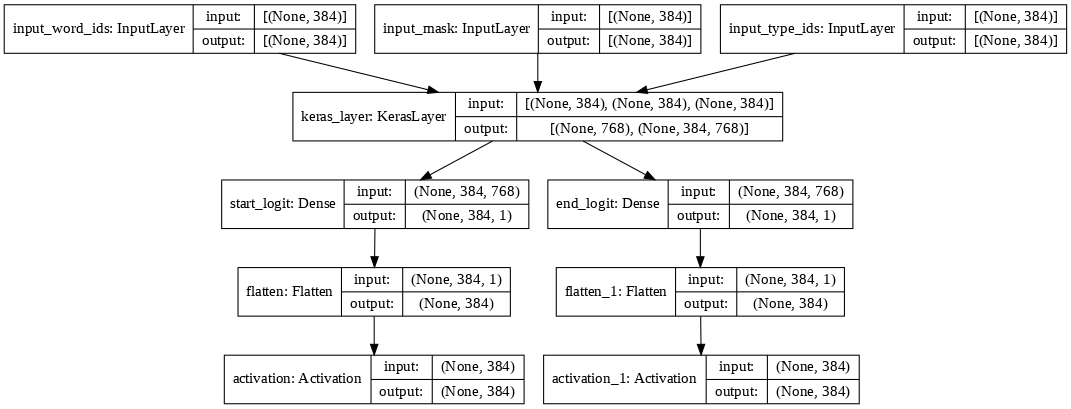

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True,dpi=76)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss])

In [ ]:
EPOCHS = 2
history = model.fit(
    train_data, validation_data = val_data,
    epochs=EPOCHS,
    verbose = 1
)

Epoch 1/2
   4402/Unknown - 3439s 778ms/step - loss: 3.8569 - activation_18_loss: 1.9542 - activation_19_loss: 1.9028

In [ ]:
model.load_weights('Artefacts/model.h5')

In [ ]:
raw_data1 = {"data":
[
{"title": "Project Apollo",
"paragraphs": [
{
"context": "The Apollo program, also known as Project Apollo, was the third United States human "
"spaceflight program carried out by the National Aeronautics and Space Administration ("
"NASA), which accomplished landing the first humans on the Moon from 1969 to 1972. First "
"conceived during Dwight D. Eisenhower's administration as a three-man spacecraft to "
"follow the one-man Project Mercury which put the first Americans in space, Apollo was "
"later dedicated to President John F. Kennedy's national goal of landing a man on the "
"Moon and returning him safely to the Earth by the end of the 1960s, which he proposed in "
"a May 25, 1961, address to Congress. Project Mercury was followed by the two-man Project "
"Gemini. The first manned flight of Apollo was in 1968. Apollo ran from 1961 to 1972, "
"and was supported by the two man Gemini program which ran concurrently with it from 1962 "
"to 1966. Gemini missions developed some of the space travel techniques that were "
"necessary for the success of the Apollo missions. Apollo used Saturn family rockets as "
"launch vehicles. Apollo/Saturn vehicles were also used for an Apollo Applications "
"Program, which consisted of Skylab, a space station that supported three manned missions "
"in 1973-74, and the Apollo-Soyuz Test Project, a joint Earth orbit mission with the "
"Soviet Union in 1975.",
"qas": [
{"question": "What project put the first Americans into space?",
"id": "Q1"
},
{"question": "What program was created to carry out these projects and missions?",
"id": "Q2"
},
{"question": "What year did the first manned Apollo flight occur?",
"id": "Q3"
},
{"question": "What President is credited with the original notion of putting Americans in space?",
"id": "Q4"
},
{"question": "Who did the U.S. collaborate with on an Earth orbit mission in 1975?",
"id": "Q5"
},
{"question": "How long did Project Apollo run?",
"id": "Q6"
},
{"question": "What program helped develop space travel techniques that Project Apollo used?",
"id": "Q7"
},
{"question": "What space station supported three manned missions in 1973-1974?",
"id": "Q8"
}
]}]}]}

In [ ]:
raw_data = {"data":
[
{"title": "Project Apollo",
"paragraphs": [
{
"context": "My name is Swapnadeep Sarkar. I'm a NLP enthusiast"
 "I was born on 11th March, 1998. I live in India"
 "BERT stands for Bidirectional Encoder Representations For Text",
"qas": [
{"question": "What does BERT stand for?",
"id": "Q1"
}
]}]}]}

In [ ]:
def create_squad_tests(raw_data):
    inputs=0
           
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                if "answers" in qa:
                    answer_text = qa["answers"][0]["text"]
                    all_answers = [_["text"] for _ in qa["answers"]]
                    start_char_idx = qa["answers"][0]["answer_start"]
                    squad_eg = Sample(question, context, start_char_idx, answer_text, all_answers)
                else:
                    squad_eg = Sample(question, context)
                squad_eg.preprocess()
                if squad_eg.skip == False:
                    inputs=squad_eg.inputs

    inputs["input_ids"]=tf.expand_dims(inputs["input_ids"], axis=0)
    inputs["attention_mask"] = tf.expand_dims(inputs["attention_mask"], axis=0)
    inputs["token_type_ids"] = tf.expand_dims(inputs["token_type_ids"], axis=0)
    return inputs, squad_eg.context_token_to_char, squad_eg.context, squad_eg.question
                    
 

In [ ]:
test_data, context_token_to_char, context, question = create_squad_tests(raw_data)

In [ ]:
pred_start,pred_end = model.predict(test_data)

In [ ]:
import numpy as np


In [ ]:
for (start, end) in zip(pred_start, pred_end):
    
    offsets = context_token_to_char
    start = np.argmax(start)
    end = np.argmax(end)
    pred_ans = None
    if start >= len(offsets):
        continue
    pred_char_start = offsets[start][0]
    if end < len(offsets):
        pred_ans = context[pred_char_start:offsets[end][1]]
    else:
        pred_ans = context[pred_char_start:]
    
    print("Q: " + question)
    print("A: " + pred_ans)

Q: What does BERT stand for?
A: Bidirectional Encoder Representations
